In [110]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [111]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv("/Users/kwonheejin/Documents/DL/dataset/WISDM.csv", index_col=0)


def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data
df.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


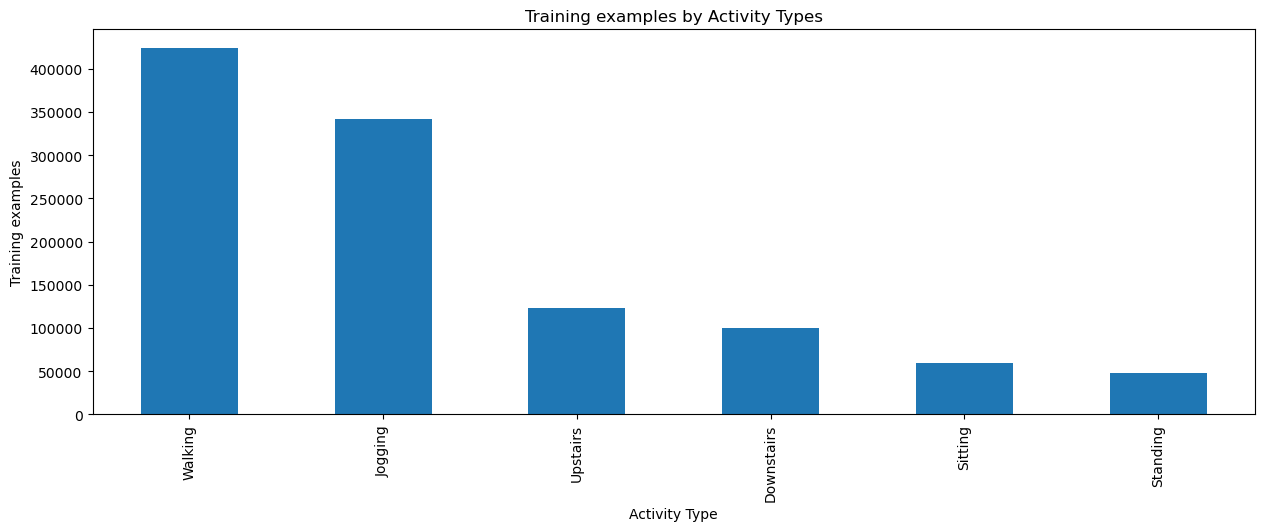

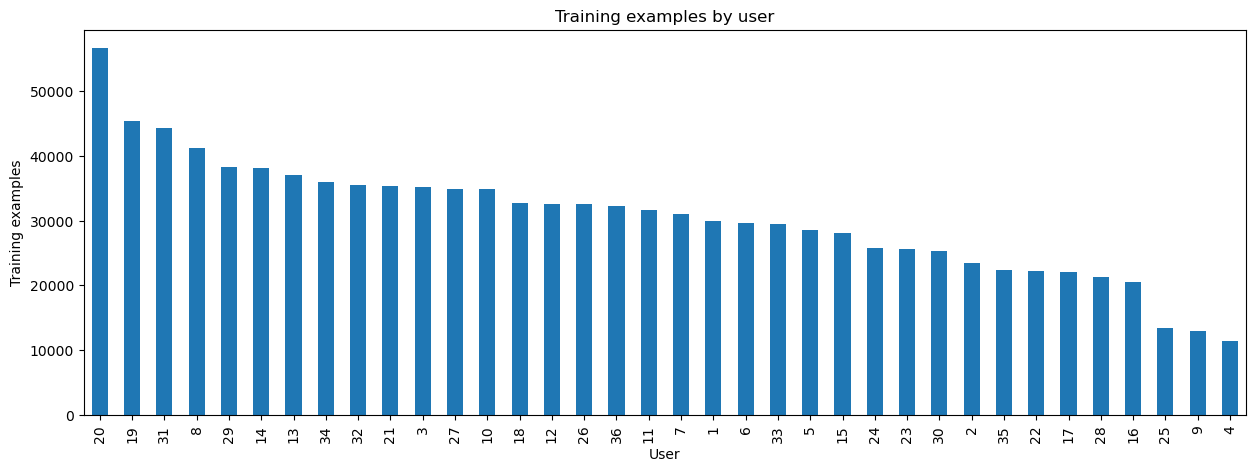

In [112]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [113]:
df.shape

(1098203, 6)

In [114]:
data.head()

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [115]:
# Walking = df[df['activity']=='Walking'].head(45000).copy()
Jogging = data[data['activity']=='Jogging'].head(45000).copy()
# Upstairs = df[df['activity']=='Upstairs'].head(24000).copy()
# Downstairs = df[df['activity']=='Downstairs'].head(24000).copy()
Sitting = data[data['activity']=='Sitting'].head(45000).copy()
# Standing = df[df['activity']=='Standing'].head(48000).copy()

In [116]:
Sitting.head()

,user-id,activity,timestamp,X,Y,Z
221333,27,Sitting,12363992261000,2.60,9.66,1.035146
221334,27,Sitting,12364042279000,2.68,9.53,0.503953
221335,27,Sitting,12364092267000,3.49,8.89,0.762740
221336,27,Sitting,12364142316000,3.64,9.38,0.926184
221337,27,Sitting,12364192273000,2.91,9.34,1.035146


In [117]:
Sitting.shape

(45000, 6)

In [118]:
import pandas as pd
balanced_data = pd.DataFrame()
balanced_data = pd.concat([balanced_data,Jogging, Sitting])
balanced_data.shape

(90000, 6)

In [119]:
balanced_data['activity'].value_counts()

Jogging    45000
Sitting    45000
Name: activity, dtype: int64

In [120]:
balanced_data['activity'] = balanced_data['activity'].replace({'Jogging': 1, 'Sitting': 0})

print(balanced_data['activity'].value_counts())

1    45000
0    45000
Name: activity, dtype: int64


In [121]:
balanced_data.head()

,user-id,activity,timestamp,X,Y,Z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [122]:
balanced_data = balanced_data.drop(['timestamp', 'user-id'], axis=1)
balanced_data.head()

,activity,X,Y,Z
0,1,-0.694638,12.680544,0.503953
1,1,5.012288,11.264028,0.953424
2,1,4.903325,10.882658,-0.081722
3,1,-0.612916,18.496431,3.023717
4,1,-1.184970,12.108489,7.205164


In [123]:
from sklearn.model_selection import train_test_split

# Assuming 'balanced_data' is your DataFrame with the updated 'activity' column
# Features (X) and labels (y)
X = balanced_data.drop('activity', axis=1)  # Assuming 'activity' is the target column
y = balanced_data['activity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (67500, 3)
X_test shape: (22500, 3)
y_train shape: (67500,)
y_test shape: (22500,)


In [124]:
noise_factor = 0.50

X_train_AE_noisy = X_train.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

X_test_AE_noisy = X_test.copy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

In [125]:
X_train.head()

,X,Y,Z
397970,4.25,3.06,8.049625
107241,-0.89,-5.33,-9.888372
467050,5.90,2.45,7.890000
107901,-3.36,-9.77,-13.252599
89499,3.17,-3.68,4.249548


In [126]:
X_train_AE_noisy.head()

,X,Y,Z
397970,4.503338,2.654731,7.737300
107241,-0.310290,-5.994219,-10.393907
467050,5.943661,2.529420,7.184064
107901,-3.672732,-9.718159,-13.386449
89499,4.086387,-3.920593,4.346366


In [127]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [128]:
input_dim = X_train_AE_noisy.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [129]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 16
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train_AE_noisy, X_train_AE_noisy,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_AE_noisy, X_test_AE_noisy),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
4219/4219 [==============================] - 2s 375us/step - loss: 22.0389 - accuracy: 0.7605 - val_loss: 8.5438 - val_accuracy: 0.8740
Epoch 2/10
4219/4219 [==============================] - 2s 359us/step - loss: 7.4924 - accuracy: 0.8972 - val_loss: 6.9528 - val_accuracy: 0.9084
Epoch 3/10
4219/4219 [==============================] - 2s 358us/step - loss: 6.9022 - accuracy: 0.9193 - val_loss: 6.8116 - val_accuracy: 0.9233
Epoch 4/10
4219/4219 [==============================] - 2s 358us/step - loss: 6.8234 - accuracy: 0.9269 - val_loss: 6.7762 - val_accuracy: 0.9329
Epoch 5/10
4219/4219 [==============================] - 2s 359us/step - loss: 6.8007 - accuracy: 0.9348 - val_loss: 6.7677 - val_accuracy: 0.9358
Epoch 6/10
4219/4219 [==============================] - 2s 358us/step - loss: 6.7894 - accuracy: 0.9421 - val_loss: 6.7538 - val_accuracy: 0.9421
Epoch 7/10
4219/4219 [==============================] - 2s 358us/step - loss: 6.7839 - accuracy: 0.9447 - val_loss: 6.7471 

In [130]:
autoencoder = load_model('model.h5')

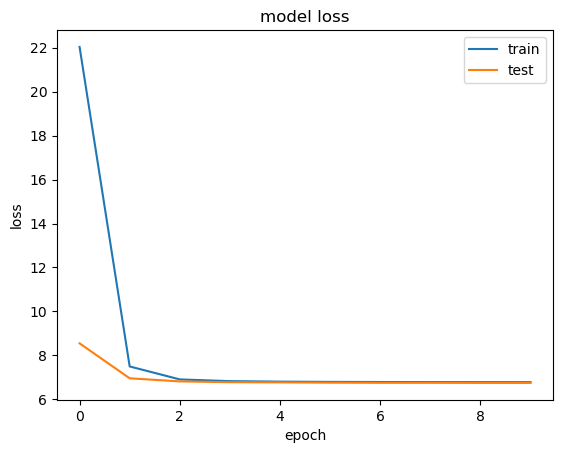

In [131]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [132]:
predictions = autoencoder.predict(X_test_AE_noisy)
mse = np.mean(np.power(X_test_AE_noisy - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

704/704 [==============================] - 0s 190us/step


,reconstruction_error,true_class
count,22500.000000,22500.000000
mean,6.741270,0.502222
std,15.980958,0.500006
min,0.000039,0.000000
25%,0.008432,0.000000
50%,0.536786,1.000000
75%,6.057472,1.000000
max,182.140156,1.000000


## normal (1) 데이터들의 재구성 오류 분포

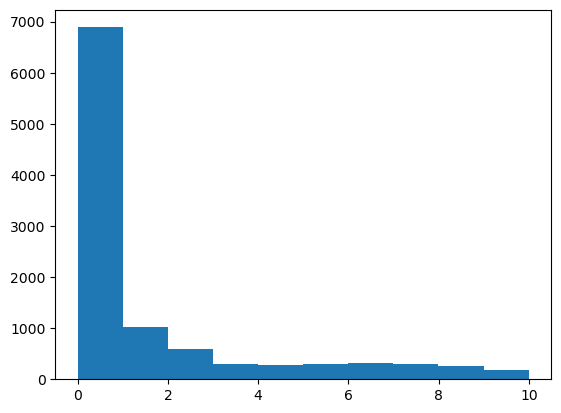

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## 0 데이터들의 재구성 오류 분포

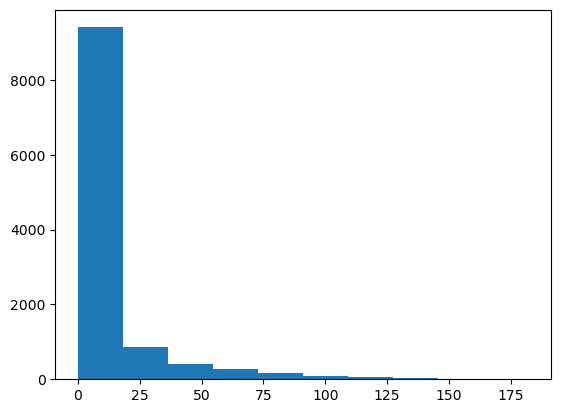

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [135]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


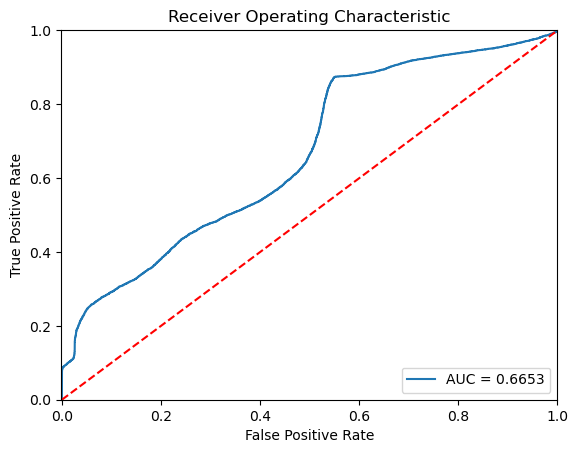

In [136]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();


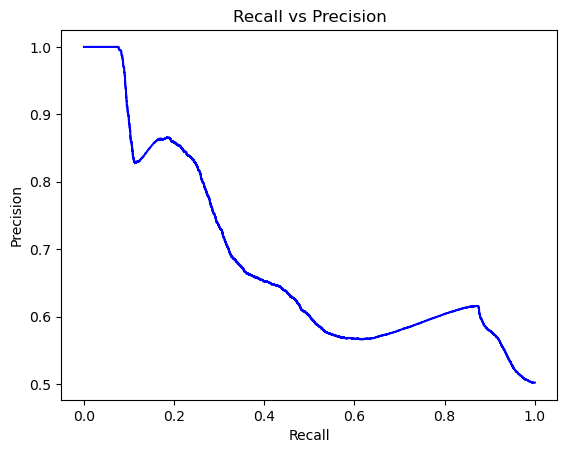

In [137]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

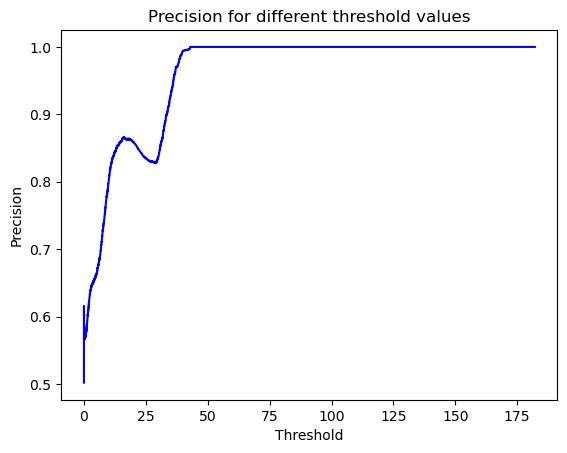

In [138]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

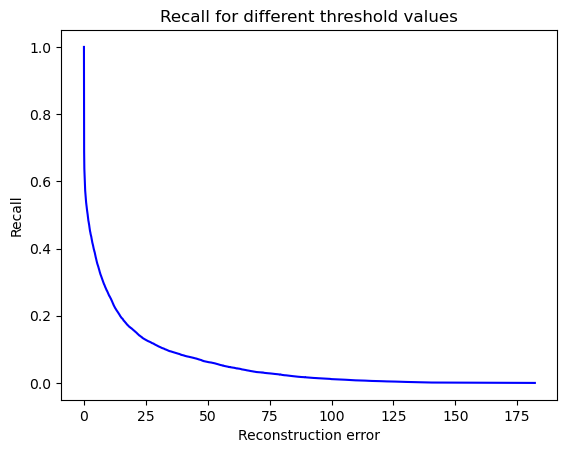

In [139]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [140]:
threshold = 2.9

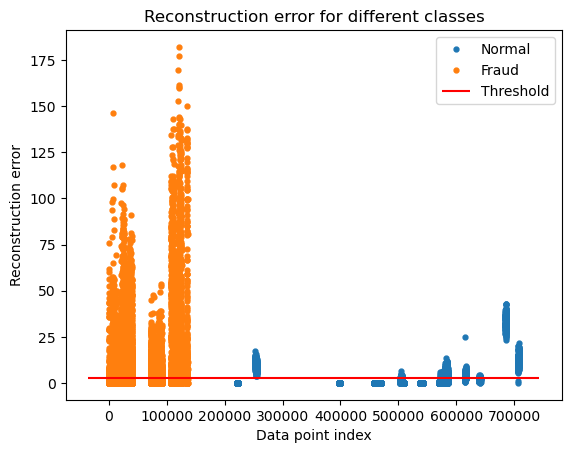

In [141]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [142]:
LABELS = [1, 0]

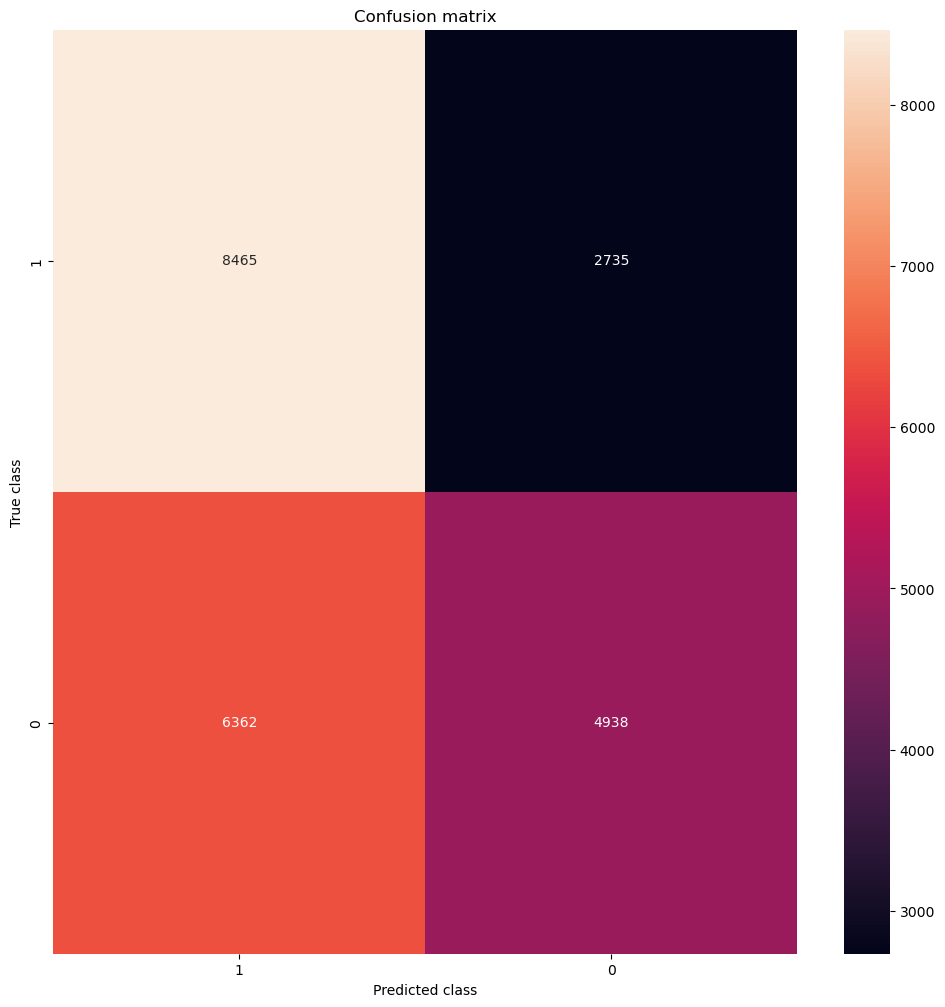

In [143]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [145]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
# print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Precision : 0.6435553238628958
Recall : 0.4369911504424779
F1 : 0.520529173035366
